Import the required packages and set up the Spark session with spark-nlp.

In [2]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2022-12-15 19:58:40--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2022-12-15 19:58:40--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2022-12-15 19:58:40--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:44

In [3]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
spark = sparknlp.start()

print("Spark NLP version: {}".format(sparknlp.version()))
print("Apache Spark version: {}".format(spark.version))

Spark NLP version: 4.2.5
Apache Spark version: 3.2.1


Load the CSV file (n=1000 samples) containing our manual labels as the target vector

In [4]:
from google.colab import files
uploaded = files.upload()

Saving GH-React.csv to GH-React.csv


In [ ]:
from pyspark.sql.functions import col
df = (spark.read
  .format("csv")
  .option("header", "true")
  .option("inferSchema", "true")
  .option("multiline", "true")
  .option("quote", '"')  
  .option("escape", "\\")
  .option("escape", '"')
  .load("GH-React.csv")
)
df = df.select(col('number'), col('title'), col('author_association'), col('body'), col('Target'))

In [6]:
# a helper function to get the shape of a Spark DF
def sparkdf_shape(df):
  return df.count(), len(df.columns)

In [7]:
print("Shape:", sparkdf_shape(df))

Shape: (1000, 5)


# Machine Learning Pipeline

## Stage 1
Split the data into training (80%) and validation(20%) sets. We will stratify based on the label since our dataset is imbalanced.

In [8]:
# create a stratified sample for the training set using a 0.8 ratio
train = df.stat.sampleBy("Target", fractions={"Bug":0.8, "Feature":0.8, "Support": 0.8, "Other": 0.8}, seed=2)
validate = df.exceptAll(train)

In [9]:
print("training set size:",train.count())
print("validation set size:",validate.count())

training set size: 799
validation set size: 201


## Stage 2
The strip_text() function is defined below. It takes in a String formatted as Markdown from GitHub and pre-processes it to return a new string ready for the next stages in our ML Pipeline.

In [10]:
import re
from pyspark.sql.functions import udf

@udf("String")
def strip_text(text):
  if text is not None:
    stripped = text.lower()    

    # remove all headings, bold text, and HTML comments from the Markdown text.
    # These items have all been used by the React team in their issue templates on GitHub
    headings_pattern = r'(<=\s|^)#{1,6}(.*?)$'
    bold_pattern = r'\*\*(.+?)\*\*(?!\*)'
    comments_pattern = r'<!--((.|\n)*?)-->'
    combined_pattern = r'|'.join((headings_pattern, bold_pattern, comments_pattern))

    stripped = re.sub(combined_pattern, '', stripped)

    # find all URLs in the string, and then remove the final directory from each to leave the general URL form
    # there may be useful patterns based on what URLs issues are commonly linking to
    url_pattern = re.compile(r'(https?://[^\s]+)')
    for url in re.findall(url_pattern, stripped):
        new_url = url.rsplit("/", 1)[0]
        stripped = stripped.replace(url, new_url)

    non_alpha_pattern = r'[^A-Za-z ]+'
    stripped = re.sub(non_alpha_pattern, '', stripped)    
    
    return ' '.join(stripped.split())
  else:
    return " "

Apply the strip_text() function to both the title and body columns in the train and validation datasets

In [11]:
train_data = train.withColumn("body", strip_text(col("body"))).withColumn("title", strip_text(col("title")))
validation_data = validate.withColumn("body", strip_text(col("body"))).withColumn("title", strip_text(col("title")))

Check that the strip_text() function worked as expected on one sample:

In [12]:
train_data.take(1)

[Row(number=11947, title='reactnativecustomtabs not return response', author_association='NONE', body='i have created button to open custontabs to use external url into reactnative app external url have some forms that are submitted and return array as a response into another page ie success page i want to get response from success page into app and customtabs would be close automatically code for custom taburl httpswwwexamplecomcustomtabsopenurlurl toolbarcolor dbenableurlbarhiding trueshowpagetitle trueenabledefaultshare trueanimations animationsslidethenlaunched boolean consoleloglaunched custom tabs launchedcatcherr consoleerrorerr', Target='Feature')]

## Stage 3 - Graeme
Create a TF-IDF features vector using a PySpark Pipeline. We will use TF-IDF applied to stemmed ngrams from both the issue title and body columns. We wi

We will apply this step separately to both the body and title to produce a different set of features for each. The tokens in the title may hold different importance than the same token in the body.

We will additionally add in the feature 'author_association' from the GitHub issue, as there may be a correlation between Members/Collaborators/Contributors submitting more valid bugs/feature requests than "None" users. This will be applied using one-hot-encoder.

In [13]:
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

In [14]:
# NLP Pipeline
documentAssemblerTitle = DocumentAssembler().setInputCol('title').setOutputCol('titles')
documentAssemblerBody = DocumentAssembler().setInputCol('body').setOutputCol('bodies')
tokenizer_titles = Tokenizer().setInputCols(['titles']).setOutputCol('tokenized_titles')
tokenizer_bodies = Tokenizer().setInputCols(['bodies']).setOutputCol('tokenized_bodies')
lemmatizer_titles = LemmatizerModel.pretrained().setInputCols(['tokenized_titles']).setOutputCol('trunc_titles')
lemmatizer_bodies = LemmatizerModel.pretrained().setInputCols(['tokenized_bodies']).setOutputCol('trunc_bodies')
ngrammer_titles = NGramGenerator().setInputCols(['trunc_titles']).setOutputCol('ngrams_titles').setN(2).setEnableCumulative(True)
ngrammer_bodies = NGramGenerator().setInputCols(['trunc_bodies']).setOutputCol('ngrams_bodies').setN(2).setEnableCumulative(True)
finisher = Finisher().setInputCols(['ngrams_titles','ngrams_bodies'])

tf_titles = CountVectorizer(inputCol='finished_ngrams_titles',outputCol='tf_features_titles')
tf_bodies = CountVectorizer(inputCol='finished_ngrams_bodies',outputCol='tf_features_bodies')
idf_titles = IDF(inputCol='tf_features_titles', outputCol='idf_titles',minDocFreq=5)
idf_bodies = IDF(inputCol='tf_features_bodies', outputCol='idf_bodies',minDocFreq=5)
author_stringIdx = StringIndexer(inputCol="author_association", outputCol="author_index")
ohe = OneHotEncoder(inputCol="author_index", outputCol="aa")
assembler = VectorAssembler(inputCols=['aa', 'idf_titles', 'idf_bodies'],outputCol='features')
label_stringIdx = StringIndexer(inputCol = "Target", outputCol = "label")

nlp_pipe = Pipeline().setStages([documentAssemblerTitle,
                    documentAssemblerBody,
                    tokenizer_titles,
                    tokenizer_bodies,
                    lemmatizer_titles,
                    lemmatizer_bodies,
                    ngrammer_titles,
                    ngrammer_bodies,
                    finisher,
                    tf_titles,
                    tf_bodies,
                    idf_titles,
                    idf_bodies,
                    author_stringIdx,
                    ohe,
                    assembler,
                    label_stringIdx])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


**NOTE:** Spark NLP and Spark ML are not compatible in terms of the pySpark Pipeline and CrossValidate (took a very long time to learn this). We need to make the NLP pre-processing and intermediate step in the process.

Source: https://github.com/JohnSnowLabs/spark-nlp/issues/1158

We will fit/transform the NLP part of the pipeline and feed it into the Classifiers later on. This also has the added benefit of not having to re-run the NLP pre-processing on each iteration of grid search, but load it from cache instead.

In [15]:
nlp_fit = nlp_pipe.fit(train_data)
nlp_train = nlp_fit.transform(train_data)
# capturing full dataframe here to use for figs later
nlp_train_full = nlp_train
nlp_train = nlp_train.select(col('features'), col('label'))

nlp_validate = nlp_fit.transform(validation_data)
nlp_validate = nlp_validate.select(col('number'), col('features'), col('label'))

# Save to file for future reference, and load to cache
nlp_train.write.mode('overwrite').parquet("./nlp/nlp_train.parquet")
nlp_train = spark.read.parquet("./nlp/nlp_train.parquet")
nlp_train.cache()

nlp_validate.write.mode('overwrite').parquet("./nlp/nlp_validate.parquet")
nlp_validate = spark.read.parquet("./nlp/nlp_validate.parquet")
nlp_validate.cache()

DataFrame[number: int, features: vector, label: double]

## Plotting / helper functions

In [19]:
# bar/count plot helper function

import seaborn as sns
import matplotlib.pyplot as plt

def term_freq_plot(df, title):
  dfp = df.toPandas()
  sns.set_theme(style="ticks")
  plt.figure(figsize=(15,8))
  freq_plot = sns.barplot(data=dfp, x=dfp.columns[0], y=dfp.columns[1], hue=None, color='blue')
  freq_plot.set(title=title)
  for label in freq_plot.get_xticklabels():
    label.set_rotation(45)

In [20]:
# confusion matrix plotting

import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.mllib.evaluation import MulticlassMetrics
import warnings

def confusion_matrix_plotter(df_model_output, model_name, target_label='label', predict_label='prediction', reverse_xaxis='n', nparray='n'):
  
  warnings.filterwarnings("ignore")
  
  if(nparray == 'n'):
    predications_and_labels = df_model_output.select(col(predict_label),col(target_label))
    # predications_and_labels.show(5)
    metrics = MulticlassMetrics(predications_and_labels.rdd)
    confusion_matrix = metrics.confusionMatrix().toArray()
  else:
    confusion_matrix=df_model_output
  print(confusion_matrix)
  plt.figure(figsize=(10,6))
  fx=sns.heatmap(confusion_matrix, annot=True, fmt=".1f",cmap="GnBu", xticklabels=True, yticklabels=True, vmin=-1)
  fx.set_title('Confusion Matrix Results %(model_name)s \n' %{"model_name": model_name});
  fx.set_xlabel('\n Predicted Values\n')
  fx.set_ylabel('Actual Values\n');
  fx.xaxis.set_ticklabels(["Other", "Support", "Bug", "Feature"])
  fx.yaxis.set_ticklabels(["Other", "Support", "Bug", "Feature"])
  if(reverse_xaxis == 'y'):
    fx.invert_xaxis()
  plt.show()

In [21]:
# logistic regression heatmap plotter

import re
import pandas as pd

def logReg_cv_scores_heatmap(param_grid, model):
  plt.figure(figsize=(10,6))

  i = 0
  reg_Param = []
  elastic_NetParam = []

  while i < (len(param_grid)):
    result = re.search(r"(regParam).*(: (\d+.?\d+),).+(elasticNetParam).+(:.*(\d+.?\d+))", str(param_grid[i]))
    reg_Param.append(result.groups()[2])
    elastic_NetParam.append(result.groups()[5])
    i += 1

  # print(reg_Param)
  # print(elastic_NetParam)
  # print(model.avgMetrics)

  data_lists = list(zip(reg_Param, elastic_NetParam, model.avgMetrics))
  
  df_labels = ["regParam", "elasticNetParam", "Score"]

  data_df = spark.createDataFrame(data=data_lists, schema=df_labels)
  # data_df.show()

  heatmap_df = data_df.toPandas().pivot("regParam", "elasticNetParam", "Score")
  # heatmap_df.head(10)
  
  plot = sns.heatmap(heatmap_df, annot=True, fmt=".2f", linewidths=0.25, cmap = sns.cm.rocket_r)
  plot.invert_yaxis()

  return heatmap_df

In [22]:
# Naive Bayes heatmap plotter (similar to logistic regression func above
# - at this time, I just adapted the previous instead of making a more general version)

import re
import pandas as pd

def nb_cv_scores_heatmap(param_grid, model):
  plt.figure(figsize=(10,6))
  
  i = 0
  param1 = []
  param2 = []

  while i < (len(param_grid)):
    result = re.search(r"name=.+(smoothing).*:.+(\d+.?\d+),.+(modelType).+\):.*'(.+)'", str(param_grid[i]))
    # print(result.groups())
    param1.append(result.groups()[1])
    param2.append(result.groups()[3])
    i += 1

  # print(param1)
  # print(param1)
  # print(model.avgMetrics)

  data_lists = list(zip(param1, param2, model.avgMetrics))
  
  df_labels = ["smoothing", "modelType", "Score"]

  data_df = spark.createDataFrame(data=data_lists, schema=df_labels)
  data_df.show()

  heatmap_df = data_df.toPandas().pivot("smoothing", "modelType", "Score")
  heatmap_df.head(10)
  
  plot = sns.heatmap(heatmap_df, annot=True, linewidths=0.25, cmap = sns.cm.rocket_r)
  plot.invert_yaxis()

  return heatmap_df

## Title & Body (finished ngram) Figures

In [23]:
from pyspark.sql.types import StringType

df_finished_ngrams_titles = nlp_train_full.select('finished_ngrams_titles').rdd.flatMap(lambda x: x[0]).toDF(schema=StringType()).toDF('terms')
# print(df_finished_ngrams_titles.count())
# df_finished_ngrams_titles.show(5)

df_finished_ngrams_bodies = nlp_train_full.select('finished_ngrams_bodies').rdd.flatMap(lambda x: x[0]).toDF(schema=StringType()).toDF('terms')
# print(df_finished_ngrams_bodies.count())
# df_finished_ngrams_bodies.show(5)

term_freq_titles = df_finished_ngrams_titles.rdd.countByValue()
term_freq_titles_df = pd.DataFrame({'term': list(term_freq_titles.keys()),'frequency': list(term_freq_titles.values())})
title_freqs = spark.createDataFrame(term_freq_titles_df).orderBy('frequency', ascending=False)
title_freqs.show(3)
print(sparkdf_shape(title_freqs))

term_freq_body = df_finished_ngrams_bodies.rdd.countByValue()
term_freq_body_df = pd.DataFrame({'term': list(term_freq_body.keys()),'frequency': list(term_freq_body.values())})
body_freqs = spark.createDataFrame(term_freq_body_df).orderBy('frequency', ascending=False)
body_freqs.show(3)
print(sparkdf_shape(body_freqs))

+-----+---------+
| term|frequency|
+-----+---------+
|{bug}|      221|
| {in}|      197|
| {be}|      166|
+-----+---------+
only showing top 3 rows

(5899, 2)
+-----+---------+
| term|frequency|
+-----+---------+
|{the}|     4169|
| {be}|     2875|
| {to}|     2435|
+-----+---------+
only showing top 3 rows

(59550, 2)


In [24]:
import pyspark.sql.functions as F
df_title_freqs = title_freqs.select(F.col("term.terms").alias("term"), F.col("frequency").alias("count")).limit(20)
df_title_freqs.show()

df_body_freqs = body_freqs.select(F.col("term.terms").alias("term"), F.col("frequency").alias("count")).limit(20)
df_body_freqs.show()

+---------+-----+
|     term|count|
+---------+-----+
|      bug|  221|
|       in|  197|
|       be|  166|
|    react|  158|
|       to|  155|
|      not|  144|
|      the|  133|
|        a|  121|
|component|  108|
|    error|  107|
|     with|  100|
|       of|   96|
| devtools|   79|
|      for|   78|
|     when|   77|
|      and|   72|
|     hook|   66|
|      use|   62|
|       on|   58|
|    state|   56|
+---------+-----+

+---------+-----+
|     term|count|
+---------+-----+
|      the| 4169|
|       be| 2875|
|       to| 2435|
|        a| 1851|
|       in| 1707|
|        i| 1663|
|      and| 1221|
|       at| 1190|
|       it| 1138|
|     this| 1008|
|       of|  988|
|    react|  925|
|     that|  821|
|component|  768|
|      not|  713|
|      use|  642|
|      for|  600|
|     from|  599|
|       on|  576|
|     with|  558|
+---------+-----+



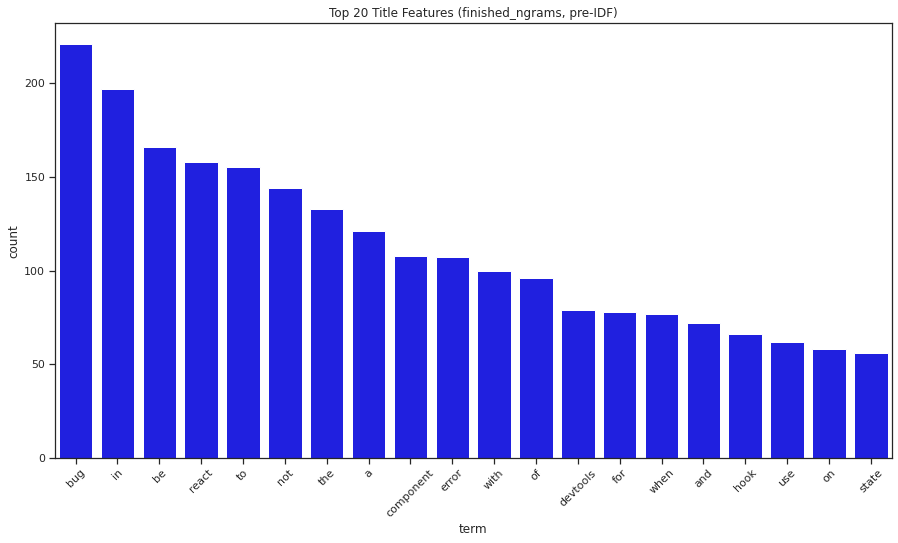

In [25]:
term_freq_plot(df_title_freqs, "Top 20 Title Features (finished_ngrams, pre-IDF)")

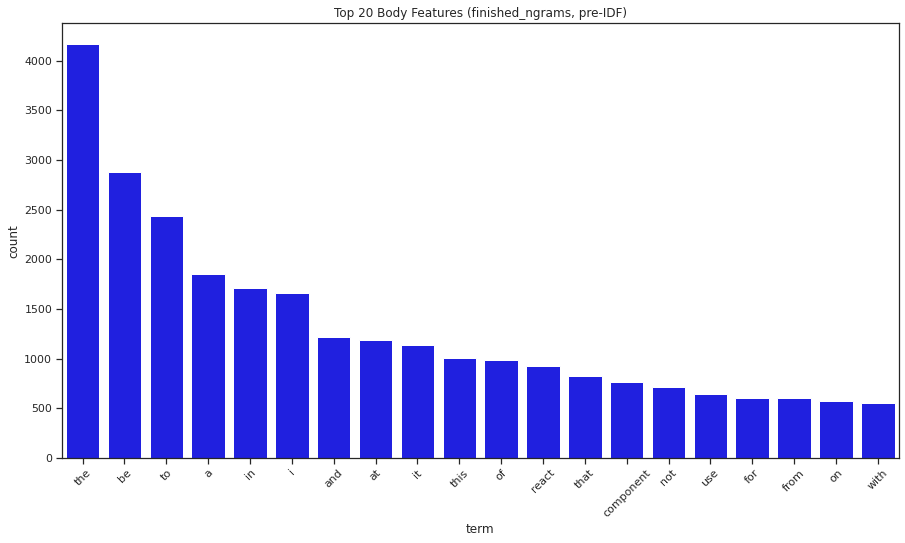

In [26]:
term_freq_plot(df_body_freqs, "Top 20 Body Features (finished_ngrams, pre-IDF)")

## Stage 4

Apply and fit the model pipeline.

First, fit and transform the pipeline with our training dataset using Logistic Regression classifier.

In [27]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()
lr_model = lr.fit(nlp_train)

In [28]:
predictions_train = lr_model.transform(nlp_train)

Evaluate the predictions. We have a perfect training score, which could be expected given that we have many more features than samples on a linear model.

In [29]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 

evaluator = MulticlassClassificationEvaluator()

accuracy = predictions_train.filter(predictions_train.label == predictions_train.prediction).count() / float(predictions_train.count())
score = evaluator.evaluate(predictions_train)
print("Train Accuracy Score: {0:.4f}".format(accuracy))
print("Train {0}: {1:.4f}".format(evaluator.getMetricName(), score))

Train Accuracy Score: 1.0000
Train f1: 1.0000


[[349.   0.   0.   0.]
 [  0. 317.   0.   0.]
 [  0.   0.  97.   0.]
 [  0.   0.   0.  36.]]


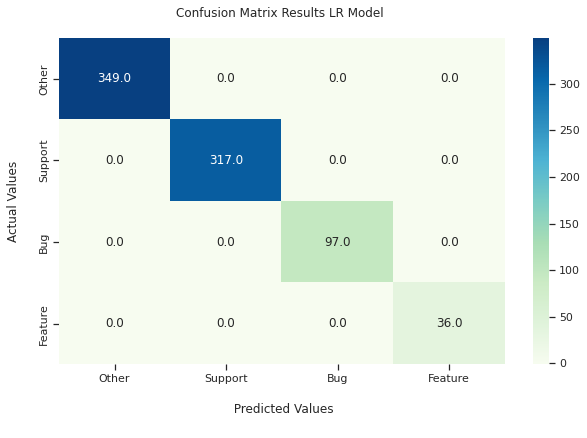

In [30]:
# call helper to plot confusion matrix
confusion_matrix_plotter(predictions_train, "LR Model")

Save the trained model for faster loading in the future:

In [31]:
from pyspark.ml.classification import LogisticRegressionModel
lr_model.write().overwrite().save("./trainedmodels/lr")
lr_model = LogisticRegressionModel.load("./trainedmodels/lr")

Now, apply the model to our validation set to see how it performs on new data:

In [32]:
predictions_validate = lr_model.transform(nlp_validate)

In [33]:
accuracy = predictions_validate.filter(predictions_validate.label == predictions_validate.prediction).count() / float(predictions_validate.count())
score = evaluator.evaluate(predictions_validate)
print("Validation Accuracy Score: {0:.4f}".format(accuracy))
print("Validation {0}: {1:.4f}".format(evaluator.getMetricName(), score))

Validation Accuracy Score: 0.4826
Validation f1: 0.4855


[[48. 18. 11.  6.]
 [33. 34.  8.  8.]
 [ 9.  7. 10.  1.]
 [ 1.  1.  1.  5.]]


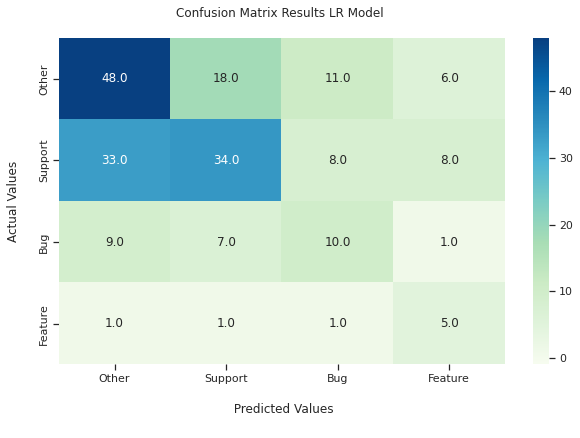

In [34]:
# call helper to plot confusion matrix
confusion_matrix_plotter(predictions_validate, "LR Model")

Take a look at the confusion matrix to see where the model made its mistakes:

In [35]:
# generate the hits/misses
confusion_table = predictions_validate.groupBy('label','prediction').count()

# Get the labels back from the model
from pyspark.ml.feature import IndexToString
t_labels = IndexToString(inputCol="label", outputCol="TargetLabel")
p_labels = IndexToString(inputCol='prediction', outputCol="PredictionLabel", labels=["Other", "Support", "Bug", "Feature"]) 

confusion_table = t_labels.transform(confusion_table)
confusion_table = p_labels.transform(confusion_table)
confusion_table = confusion_table.select(col("TargetLabel"), col("PredictionLabel"), col("count"))

#display the table with the confusion results
confusion_table.show()

+-----------+---------------+-----+
|TargetLabel|PredictionLabel|count|
+-----------+---------------+-----+
|        Bug|          Other|    9|
|    Support|        Support|   34|
|    Feature|            Bug|    1|
|      Other|        Support|   18|
|        Bug|            Bug|   10|
|    Support|          Other|   33|
|    Feature|        Support|    1|
|        Bug|        Feature|    1|
|        Bug|        Support|    7|
|    Support|            Bug|    8|
|      Other|          Other|   48|
|    Support|        Feature|    8|
|      Other|            Bug|   11|
|    Feature|        Feature|    5|
|      Other|        Feature|    6|
|    Feature|          Other|    1|
+-----------+---------------+-----+



## Stage 5

Grid Search for optimizing model

### Logistic Regression

Use grid search with cross validate to find potentially better model parameters.

We will use the lr (LogisticRegression classifier) we created earlier

In [36]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np


paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0, 0.01, 0.1, 1, 10]) \
    .addGrid(lr.elasticNetParam, [0, 1]) \
    .build()

# MCE metricName="f1" (default scoring metric)
evaluator = MulticlassClassificationEvaluator()

cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid_lr,
                    evaluator=evaluator,
                    numFolds=5,
                    seed=9)

# use the output from the NLP train pipeline
cvModel = cv.fit(nlp_train)

In [37]:
# save the model to make future analysis easier (won't have to re-perform grid search)
from pyspark.ml.tuning import CrossValidatorModel
cvModel.write().overwrite().save("./trainedmodels/cvlr")
cvModel = CrossValidatorModel.load("./trainedmodels/cvlr")

In [38]:
# the parameters for the best model:
cvModel.bestModel.extractParamMap()

{Param(parent='LogisticRegression_7c337dfc6106', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LogisticRegression_7c337dfc6106', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
 Param(parent='LogisticRegression_7c337dfc6106', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto',
 Param(parent='LogisticRegression_7c337dfc6106', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LogisticRegression_7c337dfc6106', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LogisticRegression_7c337dfc6106', name='labelCol', doc='label column name.'): 'label',
 Param(parent='LogisticRegression_7c337dfc6106', name='maxBlockSizeInMB', doc='maximum memory in MB for s

In [39]:
# get the accuracy metrics for the models. This is a list.
avgMetricsGrid = cvModel.avgMetrics
print(avgMetricsGrid)
np.mean(cvModel.avgMetrics)

[0.4829413780903705, 0.4829413780903705, 0.49170877529621726, 0.4891459129227088, 0.4978882781559933, 0.2648432438321038, 0.48874479547318617, 0.2648432438321038, 0.4907794028896253, 0.2648432438321038]


0.42186796524147835

elasticNetParam,0.0,1.0
regParam,,
0.0,0.482941,0.482941
0.01,0.491709,0.489146
0.1,0.497888,0.264843
1.0,0.488745,0.264843
10.0,0.490779,0.264843


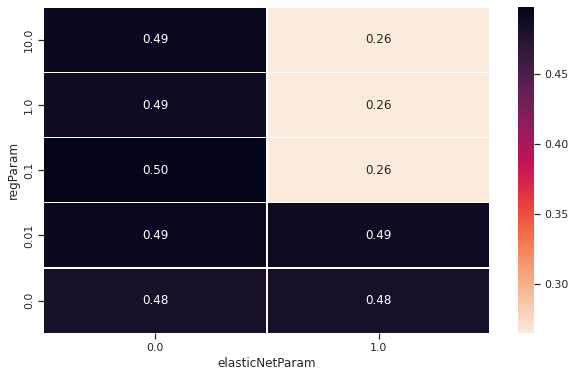

In [40]:
# call helper to plot heatmap
heatmap_df = logReg_cv_scores_heatmap(paramGrid_lr, cvModel)
heatmap_df

Now, we will fit our best model on the validation data again:

In [41]:
predictions_best_model_lr = cvModel.transform(nlp_validate)

In [42]:
accuracy = predictions_best_model_lr.filter(predictions_best_model_lr.label == predictions_best_model_lr.prediction).count() / float(predictions_best_model_lr.count())
score = evaluator.evaluate(predictions_best_model_lr)
print("Best Validation Accuracy Score (LR): {0:.4f}".format(accuracy))
print("Best Validation {0} (LR): {1:.4f}".format(evaluator.getMetricName(), score))

Best Validation Accuracy Score (LR): 0.5274
Best Validation f1 (LR): 0.4996


In [43]:
# generate the hits/misses
confusion_table = predictions_best_model_lr.groupBy('label','prediction').count()

# Get the labels back from the model
from pyspark.ml.feature import IndexToString
t_labels = IndexToString(inputCol="label", outputCol="TargetLabel")
p_labels = IndexToString(inputCol='prediction', outputCol="PredictionLabel", labels=["Other", "Support", "Bug", "Feature"]) 

confusion_table = t_labels.transform(confusion_table)
confusion_table = p_labels.transform(confusion_table)
confusion_table = confusion_table.select(col("TargetLabel"), col("PredictionLabel"), col("count"))

#display the table with the confusion results
confusion_table.show()

+-----------+---------------+-----+
|TargetLabel|PredictionLabel|count|
+-----------+---------------+-----+
|        Bug|          Other|   12|
|    Support|        Support|   46|
|      Other|        Support|   26|
|    Support|          Other|   37|
|        Bug|            Bug|    3|
|    Feature|        Support|    3|
|        Bug|        Feature|    1|
|        Bug|        Support|   11|
|      Other|          Other|   56|
|      Other|            Bug|    1|
|    Feature|        Feature|    1|
|    Feature|          Other|    4|
+-----------+---------------+-----+



A few more metrics:

[[56. 26.  1.  0.]
 [37. 46.  0.  0.]
 [12. 11.  3.  1.]
 [ 4.  3.  0.  1.]]


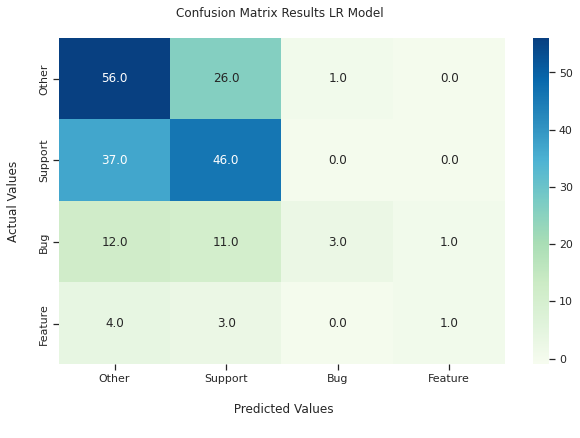

In [44]:
# call helper function to plot confusion matrix
confusion_matrix_plotter(predictions_best_model_lr, "LR Model")

In [45]:
labels = ["Other", "Support", "Bug", "Feature"]
metrics = MulticlassMetrics(predictions_best_model_lr.select(col('label'),col('prediction')).rdd)

print("Accuracy: ", metrics.accuracy)
for idx, label in enumerate(labels):
  print("Recall for {}: {}".format(label, metrics.precision(idx)))
  print("Precision for {}: {}".format(label, metrics.recall(idx)))
  print("f1 score for {}: {}".format(label, metrics.fMeasure(float(idx), 1.0)))

Accuracy:  0.527363184079602
Recall for Other: 0.6746987951807228
Precision for Other: 0.5137614678899083
f1 score for Other: 0.5833333333333333
Recall for Support: 0.5542168674698795
Precision for Support: 0.5348837209302325
f1 score for Support: 0.5443786982248521
Recall for Bug: 0.1111111111111111
Precision for Bug: 0.75
f1 score for Bug: 0.19354838709677416
Recall for Feature: 0.125
Precision for Feature: 0.5
f1 score for Feature: 0.2


In [46]:
predictions_best_model_lr.select(col('label'),col('prediction')).groupBy("label", "prediction").sum().show()

+-----+----------+----------+---------------+
|label|prediction|sum(label)|sum(prediction)|
+-----+----------+----------+---------------+
|  2.0|       0.0|      24.0|            0.0|
|  1.0|       1.0|      46.0|           46.0|
|  0.0|       1.0|       0.0|           26.0|
|  1.0|       0.0|      37.0|            0.0|
|  2.0|       2.0|       6.0|            6.0|
|  3.0|       1.0|       9.0|            3.0|
|  2.0|       3.0|       2.0|            3.0|
|  2.0|       1.0|      22.0|           11.0|
|  0.0|       0.0|       0.0|            0.0|
|  0.0|       2.0|       0.0|            2.0|
|  3.0|       3.0|       3.0|            3.0|
|  3.0|       0.0|      12.0|            0.0|
+-----+----------+----------+---------------+



### Naive Bayes
Create a new pipeline for Naive Bayes

In [47]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

nb = NaiveBayes()

paramGrid_nb = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
    .addGrid(nb.modelType, ["multinomial", "complement", "gaussian"]) \
    .build()

# MCE metricName="f1" (default scoring metric)
evaluator = MulticlassClassificationEvaluator()

cv_nb = CrossValidator(estimator=nb,
                    estimatorParamMaps=paramGrid_nb,
                    evaluator=evaluator,
                    numFolds=5,
                    seed=9)

cvModelNB = cv_nb.fit(nlp_train)

In [48]:
# save the model to make future analysis easier (won't have to re-perform grid search)
from pyspark.ml.tuning import CrossValidatorModel
cvModelNB.write().overwrite().save("./trainedmodels/cvnb")
cvModelNB = CrossValidatorModel.load("./trainedmodels/cvnb")

In [49]:
# the parameters for the best model:
cvModelNB.bestModel.extractParamMap()

{Param(parent='NaiveBayes_2e69d3d8e46e', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='NaiveBayes_2e69d3d8e46e', name='labelCol', doc='label column name.'): 'label',
 Param(parent='NaiveBayes_2e69d3d8e46e', name='modelType', doc='The model type which is a string (case-sensitive). Supported options: multinomial (default), bernoulli and gaussian.'): 'complement',
 Param(parent='NaiveBayes_2e69d3d8e46e', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='NaiveBayes_2e69d3d8e46e', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities.'): 'probability',
 Param(parent='NaiveBayes_2e69d3d8e46e', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction',
 Param(parent='NaiveBayes_2e69d3d8e46e', name='smoothing', doc=

In [50]:
# get the accuracy metrics for the models. This is a list.
import numpy as np
avgMetricsGridNB = cvModelNB.avgMetrics
print(avgMetricsGridNB)
np.mean(cvModelNB.avgMetrics)

[0.39886667303320333, 0.390487351286241, 0.4488035265700841, 0.4793758467551451, 0.5049638854590692, 0.4488035265700841, 0.48153822085517206, 0.49683112073323443, 0.4488035265700841, 0.4797111380509994, 0.4927766919293613, 0.4488035265700841, 0.48111397515063536, 0.49041983094462505, 0.4488035265700841, 0.4782675250964634, 0.48437077854641253, 0.4488035265700841]


0.46397467762561484

+---------+-----------+-------------------+
|smoothing|  modelType|              Score|
+---------+-----------+-------------------+
|      0.0|multinomial|0.39886667303320333|
|      0.0| complement|  0.390487351286241|
|      0.0|   gaussian| 0.4488035265700841|
|      0.2|multinomial| 0.4793758467551451|
|      0.2| complement| 0.5049638854590692|
|      0.2|   gaussian| 0.4488035265700841|
|      0.4|multinomial|0.48153822085517206|
|      0.4| complement|0.49683112073323443|
|      0.4|   gaussian| 0.4488035265700841|
|      0.6|multinomial| 0.4797111380509994|
|      0.6| complement| 0.4927766919293613|
|      0.6|   gaussian| 0.4488035265700841|
|      0.8|multinomial|0.48111397515063536|
|      0.8| complement|0.49041983094462505|
|      0.8|   gaussian| 0.4488035265700841|
|      1.0|multinomial| 0.4782675250964634|
|      1.0| complement|0.48437077854641253|
|      1.0|   gaussian| 0.4488035265700841|
+---------+-----------+-------------------+



modelType,complement,gaussian,multinomial
smoothing,,,
0.0,0.390487,0.448804,0.398867
0.2,0.504964,0.448804,0.479376
0.4,0.496831,0.448804,0.481538
0.6,0.492777,0.448804,0.479711
0.8,0.490420,0.448804,0.481114
1.0,0.484371,0.448804,0.478268


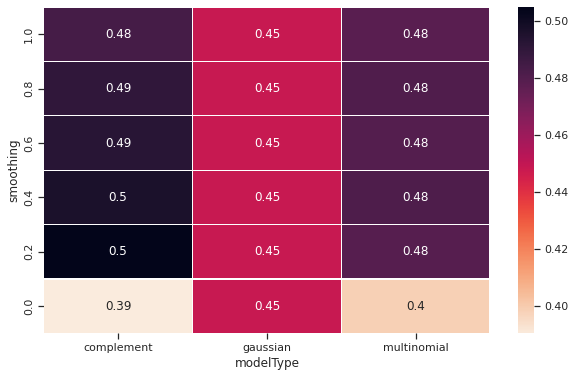

In [51]:
heatmap_nb_df = nb_cv_scores_heatmap(paramGrid_nb, cvModelNB)
heatmap_nb_df

In [52]:
predictions_best_model_nb = cvModelNB.transform(nlp_validate)

In [53]:
accuracy = predictions_best_model_nb.filter(predictions_best_model_nb.label == predictions_best_model_nb.prediction).count() / float(predictions_best_model_nb.count())
score = evaluator.evaluate(predictions_best_model_nb)
print("Best Validation Accuracy Score (NB): {0:.4f}".format(accuracy))
print("Best Validation {0} (NB): {1:.4f}".format(evaluator.getMetricName(), score))

Best Validation Accuracy Score (NB): 0.5075
Best Validation f1 (NB): 0.4699


In [54]:
# generate the hits/misses
confusion_table_nb = predictions_best_model_nb.groupBy('label','prediction').count()

# Get the labels back from the model
from pyspark.ml.feature import IndexToString
t_labels = IndexToString(inputCol="label", outputCol="TargetLabel")
p_labels = IndexToString(inputCol='prediction', outputCol="PredictionLabel", labels=["Other", "Support", "Bug", "Feature"]) 

confusion_table_nb = t_labels.transform(confusion_table_nb)
confusion_table_nb = p_labels.transform(confusion_table_nb)
confusion_table_nb = confusion_table_nb.select(col("TargetLabel"), col("PredictionLabel"), col("count"))

#display the table with the confusion results
confusion_table_nb.show()

+-----------+---------------+-----+
|TargetLabel|PredictionLabel|count|
+-----------+---------------+-----+
|        Bug|          Other|    6|
|    Support|        Support|   67|
|      Other|        Support|   46|
|    Support|          Other|   12|
|        Bug|            Bug|    2|
|    Feature|        Support|    7|
|        Bug|        Support|   19|
|    Support|            Bug|    3|
|      Other|          Other|   32|
|    Support|        Feature|    1|
|      Other|            Bug|    3|
|    Feature|        Feature|    1|
|      Other|        Feature|    2|
+-----------+---------------+-----+



Some More Metrics:

201
[[32 46  3  2]
 [12 67  3  1]
 [ 6 19  2  0]
 [ 0  7  0  1]]


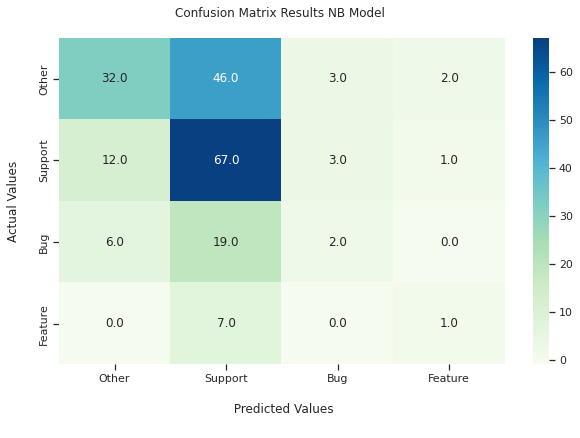

In [55]:
# generate confusion matrix w/ sklearn due to pyspark glitch (dropping 'Feature' row/col)
from sklearn.metrics import confusion_matrix
confusion_table_nb_SKL = predictions_best_model_nb

from pyspark.ml.feature import IndexToString
t_labels = IndexToString(inputCol="label", outputCol="TargetLabel")
p_labels = IndexToString(inputCol='prediction', outputCol="PredictionLabel", labels=["Other", "Support", "Bug", "Feature"]) 

confusion_table_nb_SKL = t_labels.transform(confusion_table_nb_SKL)
confusion_table_nb_SKL = p_labels.transform(confusion_table_nb_SKL)

y_true = np.array(confusion_table_nb_SKL.select(col("TargetLabel")).collect())
y_pred = np.array(confusion_table_nb_SKL.select(col("PredictionLabel")).collect())

cm = confusion_matrix(y_true, y_pred, labels=["Other", "Support", "Bug", "Feature"])
print(np.sum(cm))
confusion_matrix_plotter(cm, "NB Model", nparray='y')

[[32. 46.  3.  2.]
 [12. 67.  3.  1.]
 [ 6. 19.  2.  0.]
 [ 0.  7.  0.  1.]]


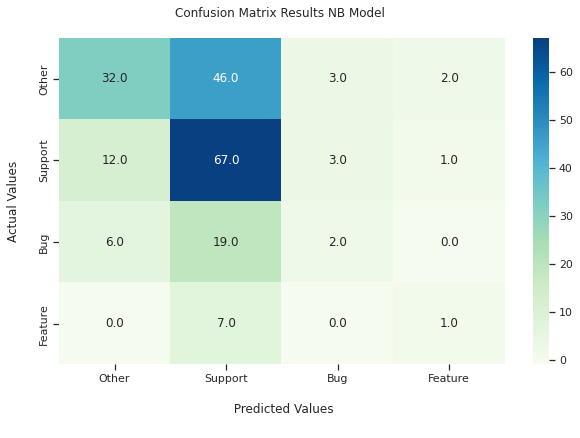

In [56]:
# call helper to plot confusion matrix
confusion_matrix_plotter(predictions_best_model_nb, "NB Model")

In [57]:
predications_and_labels = predictions_best_model_nb.select(col('label'),col('prediction'))
labels = ["Other", "Support", "Bug", "Feature"]
metrics = MulticlassMetrics(predications_and_labels.rdd)

In [58]:
print("Accuracy: ", metrics.accuracy)
for idx, label in enumerate(labels):
  print("Recall for {}: {}".format(label, metrics.precision(idx)))
  print("Precision for {}: {}".format(label, metrics.recall(idx)))
  print("f1 score for {}: {}".format(label, metrics.fMeasure(float(idx), 1.0)))

Accuracy:  0.5074626865671642
Recall for Other: 0.3855421686746988
Precision for Other: 0.64
f1 score for Other: 0.481203007518797
Recall for Support: 0.8072289156626506
Precision for Support: 0.48201438848920863
f1 score for Support: 0.6036036036036037
Recall for Bug: 0.07407407407407407
Precision for Bug: 0.25
f1 score for Bug: 0.11428571428571428
Recall for Feature: 0.125
Precision for Feature: 0.25
f1 score for Feature: 0.16666666666666666


### Post-Analysis

Generate a list of all the misclassified issues for further manual analysis. We will use the best Logistic Regression classifier from the earlier grid search since it was our best overall model.

In [59]:
# get the predictions from the model for each sample
final_predictions = predictions_best_model_lr.select(col('number'), col('prediction'))

# # Get the labels back from the model
from pyspark.ml.feature import IndexToString
p_labels = IndexToString(inputCol='prediction', outputCol="PredictionLabel", labels=["Other", "Support", "Bug", "Feature"])
final_predictions = p_labels.transform(final_predictions)

# join the predictions onto the original dataframe df, and filter for only misclassified issues
misclassified = final_predictions.join(df, (final_predictions.number == df.number) & (final_predictions.PredictionLabel == df.Target), "leftanti")
# add all columns back from the original df by inner joining
misclassified = misclassified.join(df, misclassified.number == df.number, "inner")

There are 95 total misclassified issues from the validation set.

In [60]:
misclassified.count()

95

Download the files saved by the steps above

In [61]:
# export the misclassified labels to csv and then download
panda_df = misclassified.toPandas()
panda_df.to_csv("Misclassified Issues.csv", index=False)
files.download('/content/Misclassified Issues.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#first zip the parquet files
!zip -r /content/nlp.zip /content/nlp
!zip -r /content/trainedmodels.zip /content/trainedmodels

In [63]:
#then download
files.download('/content/nlp.zip')
files.download('/content/trainedmodels.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>